## Style Transfer (Neural Style Transfer)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

import IPython.display as display
import time
import imageio

## 1. Texture 이미지 특징 추출

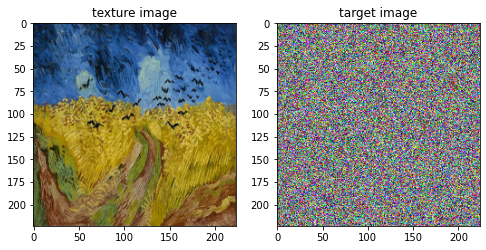

In [2]:
# 텍스쳐 이미지 불러오기
texture_path = "texture.jpeg"
texture_image = plt.imread(texture_path)
texture_image = cv2.resize(texture_image, dsize=(224, 224))
texture_image = texture_image / 255.0
input_image = tf.random.uniform(texture_image.shape)
plt.figure(figsize=[8,6])
plt.subplot(1,2,1)
plt.title("texture image")
plt.imshow(texture_image)
plt.subplot(1,2,2)
plt.title("target image")
plt.imshow(input_image)

In [3]:
# VGG-19 모델 사용
# include_top : FC layer 3개 사용 유무
# weights : 사전 학습된 가중치 출처
vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
use_layers = ['block1_conv1',
              'block2_conv1',
              'block3_conv1',
              'block4_conv1',
              'block5_conv1']
inputs = vgg.input
outputs = [vgg.get_layer(name).output for name in use_layers]

# vgg19에서 아래 outputs에서 지정한 레이어에서의 결과값을 출력으로 봄
# 따라서 위 5개 레이어에서의 특징추출결과를 출력으로 보여준다.
texture_model = tf.keras.Model(inputs=inputs,outputs=outputs)

texture 초기 입력 : [0.15686275 0.1882353  0.2627451 ]
전처리된 texture 입력 : [-36.939003 -68.779    -83.68    ]


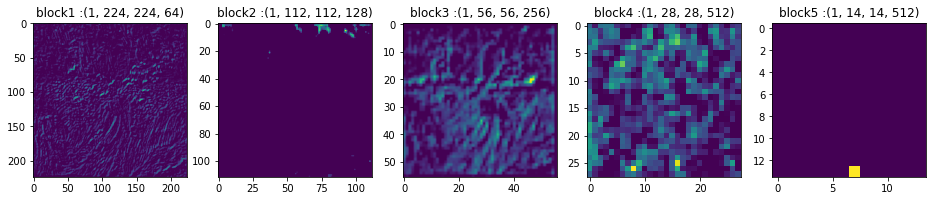

In [4]:
# texture 이미지 전처리
texture_batch = texture_image.astype('float32') # (224,224,3)
texture_batch = tf.expand_dims(texture_batch, axis=0) # (1,224,224,3)
print(f"texture 초기 입력 : {texture_batch[0][0][0]}")
inp = preprocess_input(texture_batch * 255.0)
print(f"전처리된 texture 입력 : {inp[0][0][0]}")

# 정의한 모델 통과
texture_output = texture_model(inp)

# 원본 텍스쳐 특징 추출값 확인
plt.figure(figsize=[16,10])
for idx,i in enumerate(texture_output):
    img = tf.squeeze(i[:,:,:,0],0)
    plt.subplot(1,5,idx+1)
    plt.title(f"block{idx+1} :{texture_output[idx].shape}" )
    plt.imshow(img)

In [5]:
# Gram matrix 계산 함수 정의
def gram_matrix(input_tensor):
    print(f"input tensor shape :{input_tensor.shape}")
    channels = int(input_tensor.shape[-1])
    
    # channel 제외하고 1차원으로 변환
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]

    # 변환된 같은 행렬을 서로 행렬곱수행
    gram = tf.matmul(a, a, transpose_a=True)
    print(f"output tensor shape :{gram.shape}")
    
    # 전체 길이로 나눔
    return gram / tf.cast(n, tf.float32)

# 원본 텍스쳐의 gram matrix 생성
texture_output_s = [gram_matrix(out) for out in texture_output]

input tensor shape :(1, 224, 224, 64)
output tensor shape :(64, 64)
input tensor shape :(1, 112, 112, 128)
output tensor shape :(128, 128)
input tensor shape :(1, 56, 56, 256)
output tensor shape :(256, 256)
input tensor shape :(1, 28, 28, 512)
output tensor shape :(512, 512)
input tensor shape :(1, 14, 14, 512)
output tensor shape :(512, 512)


### 1-1 LOSS (MSE) 사용

##### 타겟 텍스쳐를 업데이트하기 위한 함수 정의

In [6]:
def get_outputs(image):
    '''texture model 통과하여 gram-matrix 구하는 함수'''
    image_batch = tf.expand_dims(image, axis=0)
    inp = preprocess_input(image_batch * 255.0)
    output = texture_model(inp)
    outputs = [gram_matrix(out) for out in output]
    return outputs
  
def get_loss_bw_texture_input(input_output_s, texture_output_s):
    '''texture image의 texture model 통과 결과값과
       input image의 texture model 통과 결과값의 Loss 산출'''
    return tf.reduce_sum([tf.reduce_mean((o-s)**2) for o,s in zip(input_output_s, texture_output_s)])
  
def clip_0_1(image):
    '''clip min/max 값으로 변경됨 (근접하는 값으로)'''
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

##### Train 함수 정의

In [7]:
# tf.function과 GradientTape을 이용한 이미지 업데이트 함수 정의
opt = tf.optimizers.Adam(learning_rate=0.2, 
                         beta_1=0.99, 
                         epsilon=1e-1)

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        input_output_s = get_outputs(image)
        loss = get_loss_bw_texture_input(input_output_s, texture_output_s)
    grad = tape.gradient(loss, image) # d(loss) / d(image)
    opt.apply_gradients([(grad, image)]) # image 가중치 Update
    image.assign(clip_0_1(image)) 

##### Train 수행

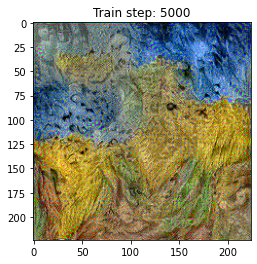

Total time: 41.7


In [8]:
start = time.time()

# backpropagation을 통해 가중치 업데이트 시, 업데이트 된 값을 저장하기위해 tf 변수지정
image = tf.Variable(input_image) 

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
    if n % 5 == 0 or n == epochs - 1:
        imageio.imwrite(f'style_image/basic/epoch_{n}.png', image.read_value().numpy())
    display.clear_output(wait=True)
    plt.imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

### 1-2 Variation Loss 추가

In [9]:
# variation loss 함수 정의
def high_pass_x_y(image):
    x_var = image[:,1:,:] - image[:,:-1,:] # 두번째 컬럼 기준 : 뒤에값 - 앞에값
    y_var = image[1:,:,:] - image[:-1,:,:] # 첫번째 컬럼 기준 : 뒤에값 - 앞에값
    return x_var, y_var

def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

In [10]:
# variation loss 비교
print('input   :', total_variation_loss(image.read_value()))
print('noise    :', total_variation_loss(tf.random.uniform(texture_image.shape)))
print('texture :', total_variation_loss(texture_image))

input   : tf.Tensor(0.08145749, shape=(), dtype=float32)
noise    : tf.Tensor(0.33329272, shape=(), dtype=float32)
texture : tf.Tensor(0.011456738825545753, shape=(), dtype=float64)


##### Train 함수 정의

In [11]:
# variation loss를 loss 계산식에 추가, 각 loss의 가중치 추가
total_variation_weight = 1e9
style_weight = 1e-1

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = get_outputs(image)
        loss = style_weight * get_loss_bw_texture_input(outputs, texture_output_s)
        loss += total_variation_weight * total_variation_loss(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

##### Train 수행

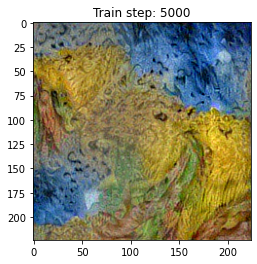

Total time: 42.4


In [12]:
start = time.time()
target_image = tf.random.uniform(texture_image.shape)

image = tf.Variable(target_image)
epochs = 50
steps_per_epoch = 100
step = 0

for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
    if n % 5 == 0 or n == epochs - 1:
        imageio.imwrite(f'style_image/variation/epoch_{n}.png', image.read_value().numpy())
    display.clear_output(wait=True)
    plt.imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [13]:
# 원본과 타겟의 variation loss 비교
print('input   :', total_variation_loss(image.read_value()))
print('texture :', total_variation_loss(texture_image))

input   : tf.Tensor(0.012593006, shape=(), dtype=float32)
texture : tf.Tensor(0.011456738825545753, shape=(), dtype=float64)


## 2. content 이미지 style transfer

초기 Content shape :(1440, 1080, 3)
전처리후 Content shape :(512, 384, 3)


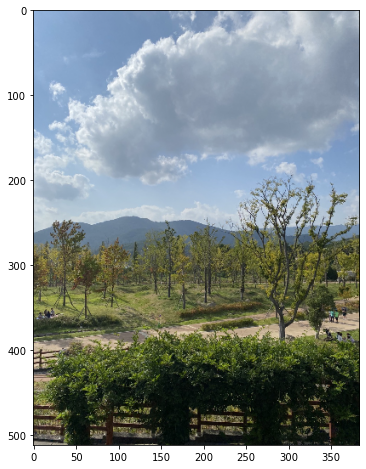

In [22]:
content_path = "content.jpeg"
content_image = plt.imread(content_path)
print(f"초기 Content shape :{content_image.shape}")

max_dim = 512
long_dim = max(content_image.shape[:-1])
scale = max_dim / long_dim
new_height = int(content_image.shape[0] * scale)
new_width = int(content_image.shape[1] * scale)

content_image = cv2.resize(content_image, dsize=(new_width, new_height))
print(f"전처리후 Content shape :{content_image.shape}")
content_image = content_image / 255.0
plt.figure(figsize=(8,8))
plt.imshow(content_image)

In [ ]:
# content 특징 추출 모델 만들기
content_batch = content_image.astype('float32')
content_batch = tf.expand_dims(content_batch, axis=0)

vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
use_layers = ['block5_conv1']
inputs = vgg.input
outputs = [vgg.get_layer(name).output for name in use_layers]
content_model = tf.keras.Model(inputs=inputs,outputs=outputs)

inp = preprocess_input(content_batch * 255.0)
content_output = content_model(inp)

In [17]:
# content output, loss 함수 정의
def get_content_output(image):
    image_batch = tf.expand_dims(image, axis=0)
    inp = preprocess_input(image_batch * 255.0)
    output = content_model(inp)
    return output

def get_content_loss(image, content_output):
    return tf.reduce_sum(tf.reduce_mean(image-content_output)**2)

##### Train 함수 정의

In [18]:
# content loss를 loss 계산식에 추가
opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.99, epsilon=1e-1)

total_variation_weight = 1e9
style_weight = 1e-2
content_weight = 1e4

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = get_outputs(image)
        output2 = get_content_output(image)
        loss = style_weight * get_loss_bw_texture_input(outputs, texture_output_s)
        loss += content_weight * get_content_loss(output2, content_output)
        loss += total_variation_weight * total_variation_loss(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

##### Train 수행

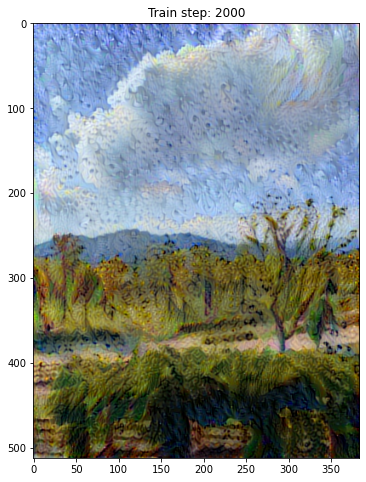

Total time: 69.4


In [19]:
# Neural Style Transfer 실행
start = time.time()
image = tf.Variable(content_image.astype('float32'))

epochs = 20
steps_per_epoch = 100
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    if n % 5 == 0 or n == epochs - 1:
        imageio.imwrite(f'style_image/transfer/style_{style_weight}_content_{content_weight}_epoch_{n}.png', image.read_value().numpy())
    display.clear_output(wait=True)
    plt.figure(figsize=(8,8))
    plt.imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))